## MLP trained on DINO embeddings

### Imports

In [181]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [182]:
embed = pd.read_parquet("../data/derived/dino_embeddings.parquet")
embed["img_id"] = embed["image_path"].str.split("/").str[-1].str.split(".").str[0] # select image id's
#print(embed["img_id"])
labels = pd.read_csv("../data/train.csv")
labels["img_id"] = labels["sample_id"].str.split("_").str[0] #select image id's
#print(labels["img_id"])
df = embed.merge(labels, on="img_id").dropna()
df.head(5)


,image_path_x,0,1,2,3,4,5,6,7,8,...,img_id,sample_id,image_path_y,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,../data/train/ID1011485656.jpg,-0.509596,-0.118388,-0.084122,-1.539088,0.529253,-0.945846,0.157166,-1.300274,-1.328233,...,ID1011485656,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
1,../data/train/ID1011485656.jpg,-0.509596,-0.118388,-0.084122,-1.539088,0.529253,-0.945846,0.157166,-1.300274,-1.328233,...,ID1011485656,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984
2,../data/train/ID1011485656.jpg,-0.509596,-0.118388,-0.084122,-1.539088,0.529253,-0.945846,0.157166,-1.300274,-1.328233,...,ID1011485656,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751
3,../data/train/ID1011485656.jpg,-0.509596,-0.118388,-0.084122,-1.539088,0.529253,-0.945846,0.157166,-1.300274,-1.328233,...,ID1011485656,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
4,../data/train/ID1011485656.jpg,-0.509596,-0.118388,-0.084122,-1.539088,0.529253,-0.945846,0.157166,-1.300274,-1.328233,...,ID1011485656,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750


In [183]:
non_feature_col_names = ["image_path_x","img_id","sample_id","image_path_y",
                         "Sampling_Date","State","Species","Pre_GSHH_NDVI",
                         "Height_Ave_cm","target_name","target"]
feature_cols = [col for col in df.columns if col not in non_feature_col_names]
target_cols = df.pivot_table(index="img_id",
                             columns="target_name",
                             values="target",
                            aggfunc="first").reset_index()
target_wide = labels.merge(target_cols,on="img_id").dropna()
target_wide.head(6)

,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target,img_id,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000,ID1011485656,0.0,31.9984,16.2751,48.2735,16.275
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984,ID1011485656,0.0,31.9984,16.2751,48.2735,16.275
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751,ID1011485656,0.0,31.9984,16.2751,48.2735,16.275
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735,ID1011485656,0.0,31.9984,16.2751,48.2735,16.275
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750,ID1011485656,0.0,31.9984,16.2751,48.2735,16.275
5,ID1012260530__Dry_Clover_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Clover_g,0.0000,ID1012260530,0.0,0.0000,7.6000,7.6000,7.600


In [184]:
target_cols = ["Dry_Clover_g","Dry_Dead_g","Dry_Green_g","Dry_Total_g","GDM_g"]

X = df[feature_cols].to_numpy(dtype=np.float32)
y = target_wide[target_cols].to_numpy(dtype=np.float32)
print(f"shape of X: {X.shape}, shape of y: {y.shape}")

shape of X: (1785, 384), shape of y: (1785, 5)


In [185]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,
                                                  random_state=42,
                                                  shuffle=True) # shuffle randomly shuffles rows so its not first 80% test etc.

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
#turn into tensors for MLP
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

print(f"X_train_scaled shape: {X_train_scaled.shape}, y_train shape: {y_train.shape},  X_val_scaled shape: {X_val_scaled.shape}, y_val shape: {y_val.shape}")


X_train_scaled shape: (1428, 384), y_train shape: (1428, 5),  X_val_scaled shape: (357, 384), y_val shape: (357, 5)


In [186]:
train_tds = TensorDataset(X_train_t,y_train_t)
val_tds = TensorDataset(X_val_t,y_val_t)

#create dataloaders

train_loader = DataLoader(train_tds,batch_size=64,shuffle=True)
val_loader = DataLoader(val_tds,batch_size=64,shuffle=False)


In [187]:
#Build MLP architecture

class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim)
        )
        #could also add LayerNorm but quite small model, maybe test later if unstable
        self.apply(self._init_weights)
    def _init_weights(self,m):
        if isinstance(m,nn.Linear):
            nn.init.kaiming_normal_(m.weight,nonlinearity="relu") #use kaiming initialisation as discussed in lecture for relu
            if m.bias is not None:
                nn.init.zeros_(m.bias)
            
        
    def forward(self, x):
        return self.net(x)

In [188]:
#Initialise model, optimiser and learning rate scheduler
in_dims = X_train.shape[1]
out_dims = y_train.shape[1]
device = "cuda" if torch.cuda.is_available() else "cpu"

#set number of epochs 
epochs = 10000

loss_fc = nn.MSELoss()
model = MLP(in_dim=in_dims,hidden_dim=256,out_dim=out_dims,dropout=0.2).to(device)
optimiser = torch.optim.AdamW(model.parameters(),lr=1e-4,weight_decay=1e-4) #see lecture for Hyperparameter ranges
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimiser,T_max=epochs) #good for small MLPs, more complex than step LR


In [189]:
#early stopping logic

best_val_loss = float("inf")
patience = 10
patience_counter = 0
best_state = None

In [ ]:
#training loop
train_loss_lst = []
val_loss_lst = []
r2_list = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimiser.zero_grad()
        preds = model(xb)
        loss = loss_fc(preds,yb)
        loss.backward()
        optimiser.step()
        train_loss += loss.item()
        #print("PRED:", preds[0])
        #print("TRUE:", yb[0])
        #print("LOSS:", loss.item())

    scheduler.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb,yb in val_loader:
            xb,yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = loss_fc(preds,yb)
            val_loss += loss.item()
    mean_train_loss = train_loss / len(train_loader)
    train_loss_lst.append(mean_train_loss)
    mean_val_loss = val_loss / len(val_loader)
    val_loss_lst.append(mean_val_loss)
    r2_val = r2_score()
    if epoch % 100 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {mean_train_loss:.10f}, Val Loss: {mean_val_loss:.4f}")
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        patience_counter = 0 
        best_state = model.state_dict()
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping with: {best_val_loss} val loss, at epoch {epoch+1}")
        break
    
if best_state is not None:
    model.load_state_dict(best_state)

Epoch 1/10000, Train Loss: 1268.9741317086, Val Loss: 1260.6741
Epoch 101/10000, Train Loss: 64.7398563883, Val Loss: 69.7953
Epoch 201/10000, Train Loss: 24.8212921308, Val Loss: 26.5692
Epoch 301/10000, Train Loss: 13.4986500118, Val Loss: 10.4874
Epoch 401/10000, Train Loss: 9.2411089358, Val Loss: 4.6334
Epoch 501/10000, Train Loss: 7.7319337389, Val Loss: 2.2962
Epoch 601/10000, Train Loss: 6.8930753210, Val Loss: 1.2998
Epoch 701/10000, Train Loss: 6.2016626856, Val Loss: 0.9618
Epoch 801/10000, Train Loss: 5.5737603851, Val Loss: 0.6669
Epoch 901/10000, Train Loss: 5.1959849441, Val Loss: 0.4971
Epoch 1001/10000, Train Loss: 5.1231473632, Val Loss: 0.4921
Epoch 1101/10000, Train Loss: 5.0341684922, Val Loss: 0.3835
Epoch 1201/10000, Train Loss: 4.9142170471, Val Loss: 0.3293
Epoch 1301/10000, Train Loss: 4.6945434239, Val Loss: 0.2439
Epoch 1401/10000, Train Loss: 4.9478757278, Val Loss: 0.2857
Epoch 1501/10000, Train Loss: 4.2516844376, Val Loss: 0.2862
Epoch 1601/10000, Train 

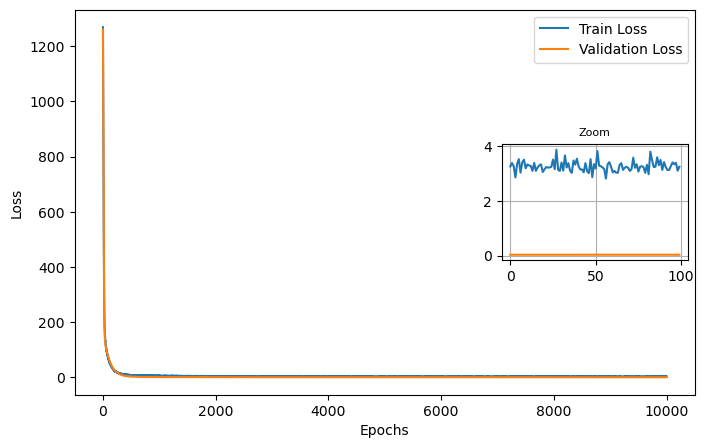

In [191]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(8,5))

ax.plot(train_loss_lst, label="Train Loss")
ax.plot(val_loss_lst, label="Validation Loss")

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend(loc="upper right")

# Inset plot
ax_inset = inset_axes(ax, width="30%", height="30%", loc="center right")

start = len(train_loss_lst) - 100
end = len(train_loss_lst)

ax_inset.plot(train_loss_lst[start:end])
ax_inset.plot(val_loss_lst[start:end])
ax_inset.set_title("Zoom", fontsize=8)
ax_inset.grid(True)

plt.show()
